In [5]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
import glob 
import re
csv_files = glob.glob('C:/Users/pablo/Desktop/scripts tfg/archivos min/*.min')

# Create an empty dataframe to store the combined data
combined_df_min = pd.DataFrame()
ind=['min HFB','min PNP','min PNPAMP']
combined_df_min.index=ind
difE=[]
list_zn=[]
# Loop through each CSV file and append its contents to the combined dataframe
for csv_file in csv_files:
    df = pd.read_csv(csv_file,sep=' ',header=None)
    df.columns=['beta_2','E HFB','E PNP', 'E PNPAMP']
    zn=[int(s) for s in re.findall(r'\d+', csv_file)] 
    list_zn.append(zn)
    E_hfb=df.iloc[0,1]
    E_pnpamp=df.iloc[2,3]
    difE.append(E_pnpamp-E_hfb)



In [4]:
size=0
for i in range(len(list_zn)):
    z,n= list_zn[i]
    if (z>=16 and z<=24) or (z>=48 and z<=60):
        size+=1
zn_train=np.zeros((size,2))
E_train=np.zeros(size)
j=0
for i in range(len(list_zn)):
    z,n= list_zn[i]
    if (z>=16 and z<=24) or (z>=48 and z<=60):
        zn_train[j][0]=z
        zn_train[j][1]=n
        E_train[j]=difE[i]
        j+=1



In [3]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1000)
        self.fc2 = nn.Linear(1000, 1750) 
        self.fc3 = nn.Linear(1750, output_dim)
        self.activation=nn.ReLU()
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)        
        self.batchnorm1=nn.BatchNorm1d(1000, eps=1e-05, momentum=None)
        self.batchnorm2=nn.BatchNorm1d(1750, eps=1e-05, momentum=None)
    def forward(self, x):
        x1 = self.activation(self.fc1(x))
        x1= self.batchnorm1(x1)
        x2 = self.activation(self.fc2(x1))
        x2=self.batchnorm2(x2)
        y=self.activation(self.fc3(x2))
        return y 


In [4]:
x=torch.tensor(list_zn)
y=torch.tensor(np.abs(difE))

#x_train=torch.tensor(zn_train)


In [16]:
from torch.utils.data import TensorDataset, DataLoader

def create_dataloaders(x, y, split_ratio):
    dataset = TensorDataset(x, y)

    train_size = int(len(dataset) * split_ratio)
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset,batch_size=train_size, shuffle=True)
    test_loader = DataLoader(test_dataset,batch_size=test_size, shuffle=False)

    return train_loader, test_loader

In [40]:
def training_model(data_size, learning_rate): 
    train_loader, test_loader = create_dataloaders(x,y,split_ratio=data_size)
    net_slice=MyModel(2,1)
    net_slice=net_slice.float()
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(net_slice.parameters(), lr=learning_rate, momentum=0.9)
    #start_time=time.time()        
    dloss=1
    loss_item=[]
    loss_item.append(0.0)
    i=0 
    nepoch=0
    while dloss > 1e-2:
        for x_train_slice, y_train_slice in train_loader:
            x_train_slice = x_train_slice.float()
            y_train_slice = y_train_slice.float()
            hatY_slice = net_slice.forward(x_train_slice)
            optimizer.zero_grad()
            loss_slice = criterion(hatY_slice, y_train_slice)
            loss_slice.backward()
            optimizer.step()
            # solo sobre el test    
            #acc=np.std()#loss segun tamaño entreno y test y varianza
            #entrenar sobre las propias energías
            #hablar sobre tiempos de computación
            #rel_acc=acc/y_test.mean()
            if nepoch % 100 == 0:
                loss_item.append(loss_slice.item())
                dloss=np.abs(loss_item[i+1]-loss_item[i])
                i+=1
        nepoch+=1
            
    #elapsed_time = time.time() - start_time
    for x_test_slice, y_test_slice in test_loader:
        x_test_slice=x_test_slice.float()
        y_test_slice=y_test_slice.float()
        hatY_pred_slice=net_slice.forward(x_test_slice)
        hatY_detach_slice=hatY_pred_slice.detach()
        total_loss_slice=criterion(hatY_detach_slice,y_test_slice)
    return total_loss_slice, dloss, loss_slice, nepoch, hatY_slice, hatY_pred_slice


In [51]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('loss',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "{0:.01f}".format( data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{data\\ size}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()
    

In [43]:
#grid search
learning_rates=np.logspace(-5,-1,5)
data_sizes=np.array([0.3,0.4,0.5,0.6,0.7,0.8])
test_loss=np.zeros((len(data_sizes), len(learning_rates)))
train_loss= np.zeros_like(test_loss)
nepochs=np.zeros_like(test_loss)
fontsize=16
for a_iter, data_size in enumerate(data_sizes):
    for b_iter, learning_rate in enumerate(learning_rates):
        total_loss_slice, dloss, loss_slice, i, hatY_slice, hatY_pred_slice=training_model(data_size=data_size, learning_rate=learning_rate)
        test_loss[a_iter,b_iter]=total_loss_slice.item()
        train_loss[a_iter, b_iter]=loss_slice.item()
        nepochs[a_iter,b_iter]=i



c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([513])) that is different to the input size (torch.Size([513, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1199])) that is different to the input size (torch.Size([1199, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([684])) that is different to the input size (torch.Size([684, 1])). This will likely lead to 

C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


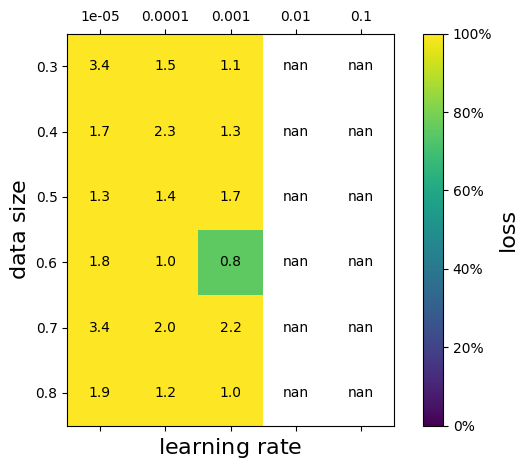

In [52]:
plot_data(learning_rates, data_sizes, test_loss)

C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\pablo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


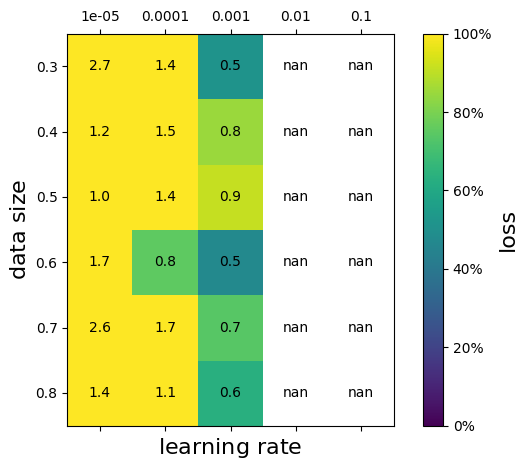

In [53]:
plot_data(learning_rates, data_sizes, train_loss)

In [46]:
nepochs

array([[6001.,  701.,  401.,  101.,  101.],
       [4301., 1101.,  301.,  101.,  101.],
       [6901.,  601.,  301.,  101.,  101.],
       [2301., 1301.,  401.,  101.,  101.],
       [6401., 1001.,  301.,  101.,  101.],
       [3501.,  701.,  301.,  101.,  101.]])

In [ ]:
train_loss_save=train_loss
np.savetxt('data_train_random_adam.csv', torch.column_stack((x_train_slice, y_train_slice)).numpy(), delimiter=',', header='Z,N,Y', comments='')
np.savetxt('data_test_random_adam.csv', torch.column_stack((x_test_slice, y_test_slice)).numpy(), delimiter=',', header='Z,N,Y', comments='')

In [19]:
x_train_slice=x[0::2, :].float()
y_train_slice=y[0::2].float()
net_slice=MyModel(2,1)
y_test_slice=y[1::2].float()
x_test_slice=x[1::2, :].float()
net_slice=net_slice.float()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(net_slice.parameters(), lr=1e-2)
for nepoch in range(2000):
    hatY_slice = net_slice.forward(x_train_slice)
    optimizer.zero_grad()
    loss_slice = criterion(hatY_slice, y_train_slice)
    loss_slice.backward()
    optimizer.step()
    # solo sobre el test    
    #acc=np.std()#loss segun tamaño entreno y test y varianza
    #entrenar sobre las propias energías
    #hablar sobre tiempos de computación
    #rel_acc=acc/y_test.mean()
    if nepoch % 100 == 0:
        print(f"loss for {nepoch} = {loss_slice.item():0.2f}")

hatY_pred_slice=net_slice.forward(x_test_slice)
hatY_detach_slice=hatY_pred_slice.detach()
total_loss_slice=criterion(hatY_detach_slice,y_test_slice)
print(total_loss_slice.item())

c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([856])) that is different to the input size (torch.Size([856, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss for 0 = 13.91
loss for 100 = 0.41
loss for 200 = 0.41
loss for 300 = 0.44
loss for 400 = 0.41
loss for 500 = 0.40
loss for 600 = 0.40
loss for 700 = 0.40


KeyboardInterrupt: 

In [20]:
hatY_pred_slice=net_slice.forward(x_test_slice)
hatY_detach_slice=hatY_pred_slice.detach()
total_loss_slice=criterion(hatY_detach_slice,y_test_slice)
print(total_loss_slice.item())

0.4323063790798187


In [70]:
x_train=x_train.float()
y_train=y_train.float()
red=model(x_train)
red=red.float()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(red.parameters(), lr=1e-2)
for nepoch in range(1000):
    hatY = red.forward(x_train)
    optimizer.zero_grad()
    loss = criterion(hatY, y_train)
    loss.backward()
    optimizer.step()
    if nepoch % 100 == 0:
        print(f"{nepoch} {loss.item():0.2f} ")

TypeError: relu(): argument 'input' (position 1) must be Tensor, not NoneType

In [102]:
x=x.float()
for size in range(0,1000,500):
    begin=size
    end=size+500
    x_batch= x[begin:end]
    y_batch=y[begin:end]
    hatY_total=net.forward(x_batch)
    total_loss=criterion(hatY_total,y_batch)
    print(total_loss)

tensor(1.5367, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.8539, dtype=torch.float64, grad_fn=<MseLossBackward0>)


c:\Users\pablo\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [18]:
print(total_loss.item())

6.609171278989821


In [29]:
from torch import concat


hatY_total=concat((hatY, hatY_pred))

In [30]:
hatY_total.shape

torch.Size([1712, 1])

array([0.81649658, 0.94280904])

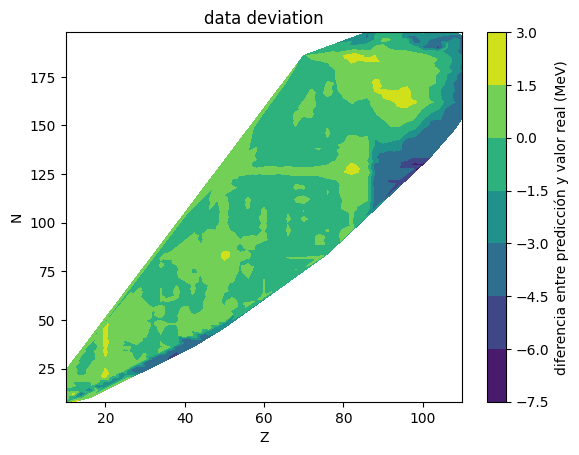

<Figure size 640x480 with 0 Axes>

In [34]:
fig, ax=plt.subplots()
pintar=hatY_total.detach()
contour= ax.tricontourf(x[:,0],x[:,1],pintar[:,0]-y)
ax.set_xlabel('Z')
ax.set_ylabel('N')
ax.set_title('data deviation')

cbar = fig.colorbar(contour)
cbar.set_label('diferencia entre predicción y valor real (MeV)')
plt.show()
plt.savefig('grafica con tres cuartos de la poblacion.png')

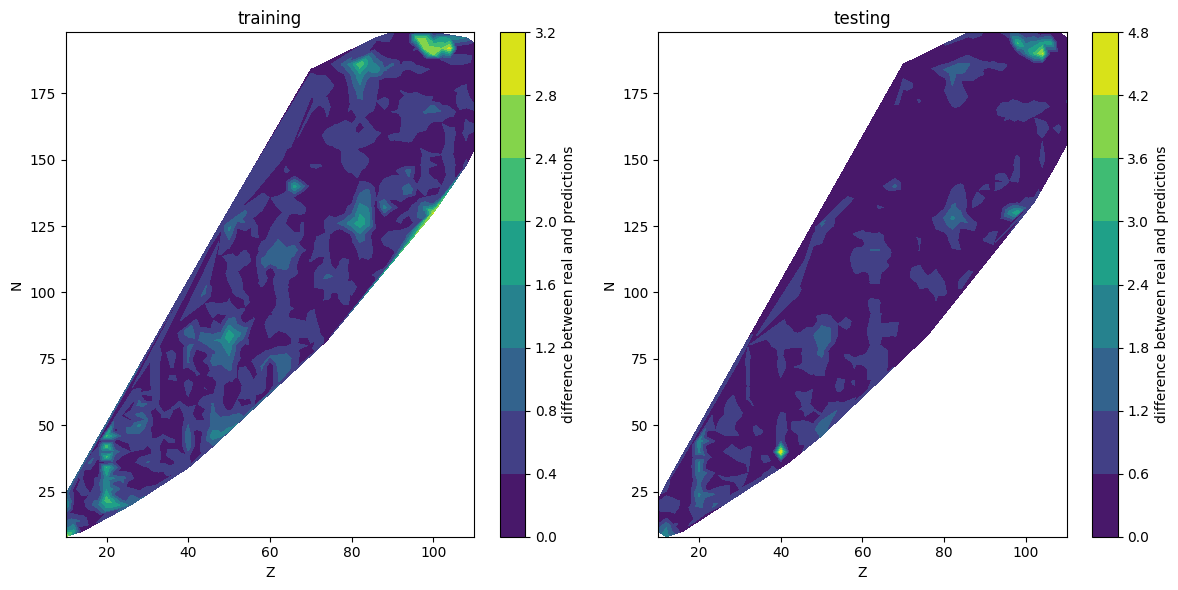

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First subplot for the even indexed data
pintar1= hatY_slice.detach()
contour1 = ax1.tricontourf(x_train_slice[:, 0], x_train_slice[:, 1], np.abs(pintar1[:, 0]-y_train_slice))
fig.colorbar(contour1, ax=ax1, label='difference between real and predictions')
ax1.set_xlabel('Z')
ax1.set_ylabel('N')
ax1.set_title('training')

# Second subplot for the odd indexed data
contour2 = ax2.tricontourf(x_test_slice[:, 0], x_test_slice[:, 1], np.abs(hatY_detach_slice[:, 0]-y_test_slice))
fig.colorbar(contour2, ax=ax2, label='difference between real and predictions')
ax2.set_xlabel('Z')
ax2.set_ylabel('N')
ax2.set_title('testing')

# Display the plot
plt.tight_layout()
plt.show()
plt.savefig('grafica con media poblacion aleatoria.png')


In [39]:
np.savetxt('data_train_random.csv', torch.column_stack((x_train_slice, y_train_slice)).numpy(), delimiter=',', header='Z,N,Y', comments='')
np.savetxt('data_test_random.csv', torch.column_stack((x_test_slice, y_test_slice)).numpy(), delimiter=',', header='Z,N,Y', comments='')
np.savetxt('data_train_three_quarters.csv', torch.column_stack((x_train, y_train)).numpy(), delimiter=',', header='Z,N,Y', comments='')
np.savetxt('data_test_three_quarters.csv', torch.column_stack((x_test, y_test)).numpy(), delimiter=',', header='Z,N,Y', comments='')


In [22]:
np.savetxt('data_train_random_adam.csv', torch.column_stack((x_train_slice, y_train_slice)).numpy(), delimiter=',', header='Z,N,Y', comments='')
np.savetxt('data_test_random_adam.csv', torch.column_stack((x_test_slice, y_test_slice)).numpy(), delimiter=',', header='Z,N,Y', comments='')

In [23]:
np.savetxt('data_difE.csv', torch.column_stack((x, y)).numpy(), delimiter=',', header='Z,N,Y', comments='')